<a href="https://colab.research.google.com/github/saipuneet357/AutoEncoders/blob/main/build_variationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Lambda, Dense, Flatten, Reshape
from keras.models import Model
from keras.optimizers import RMSprop
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras import backend as K

In [3]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
location = '/content/gdrive/MyDrive/NotMnist'  

In [5]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [6]:
train_data = extract_data(location+'/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data(location+'/t10k-images-idx3-ubyte.gz', 10000)

In [7]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [8]:
train_labels = extract_labels(location+'/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels(location+'/t10k-labels-idx1-ubyte.gz',10000)

In [9]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [10]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: D)')

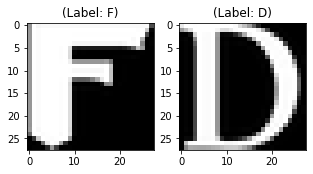

In [11]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [12]:
train_data = train_data.reshape(-1,28,28,1)
test_data = test_data.reshape(-1, 28, 28, 1)
train_data = train_data/np.max(train_data)
test_data = test_data/np.max(test_data)
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [13]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
latent_dim = 2

In [14]:
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
conv3_shape = K.int_shape(conv3)[1:]
print(conv3_shape)

(7, 7, 128)


In [15]:
x = Flatten()(conv3)
x = Dense(32, activation='relu')(x)
print(K.int_shape(x))

(None, 32)


In [16]:
z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)

In [17]:
def sample_z(args):
  z_mu, z_sigma = args
  epsilon = K.random_normal(shape=K.shape(z_mu), mean=0.0, stddev=1.0)
  return z_mu + K.exp(z_sigma/2)*epsilon

In [18]:
z = Lambda(sample_z, name='z')([z_mu, z_sigma])

In [19]:
encoder = Model(input_img, z, name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       max_pooling2d[0][0]              
____________________________________________________________________________________________

In [20]:
decoder_input = Input(shape = (latent_dim), name='decoder_input')
real_dim = Dense(np.prod(conv3_shape), name='real_dim')(decoder_input)
reshape = Reshape(conv3_shape)(real_dim)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(reshape) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
decoder = Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
real_dim (Dense)             (None, 6272)              18816     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0   

In [21]:
vae_input = Input(shape=(input_img.shape[1], input_img.shape[2], input_img.shape[3]), name='VAE_input')

In [22]:
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = Model(vae_input, vae_decoder_output, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 293540    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         240769    
Total params: 534,309
Trainable params: 534,309
Non-trainable params: 0
_________________________________________________________________


In [23]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss
vae.compile(optimizer='adam', loss=loss_func(z_mu, z_sigma))

In [24]:
vae_train = vae.fit(train_X, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_X))

Epoch 1/20
375/375 [==============================] - 50s 15ms/step - loss: 152.5529 - val_loss: 119.7279
Epoch 2/20
375/375 [==============================] - 5s 13ms/step - loss: 119.0134 - val_loss: 113.2214
Epoch 3/20
375/375 [==============================] - 5s 13ms/step - loss: 112.6243 - val_loss: 109.5058
Epoch 4/20
375/375 [==============================] - 5s 13ms/step - loss: 109.4447 - val_loss: 107.1344
Epoch 5/20
375/375 [==============================] - 5s 13ms/step - loss: 108.2649 - val_loss: 106.5251
Epoch 6/20
375/375 [==============================] - 5s 13ms/step - loss: 105.6855 - val_loss: 103.7954
Epoch 7/20
375/375 [==============================] - 5s 13ms/step - loss: 104.0130 - val_loss: 103.0073
Epoch 8/20
375/375 [==============================] - 5s 13ms/step - loss: 103.3676 - val_loss: 102.4978
Epoch 9/20
375/375 [==============================] - 5s 13ms/step - loss: 102.1356 - val_loss: 101.4687
Epoch 10/20
375/375 [==============================] -

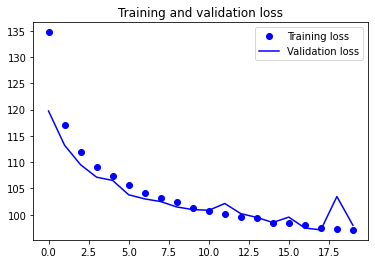

In [25]:
loss = vae_train.history['loss']
val_loss = vae_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
pred = vae.predict(test_data)

Real Image


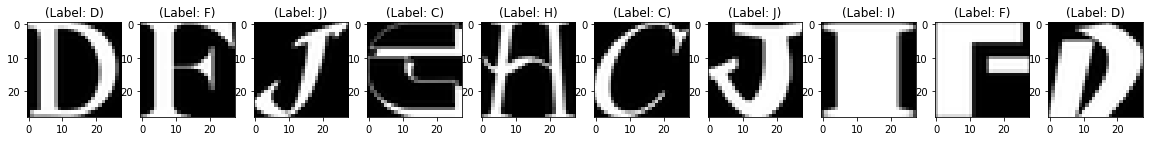

Reconstruction of Test Images


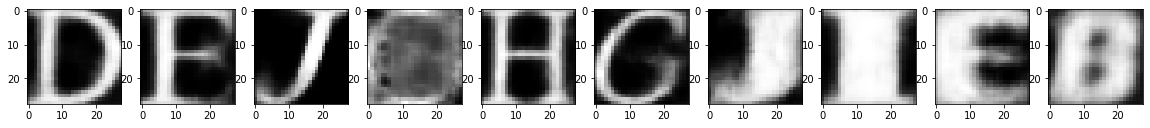

In [29]:
plt.figure(figsize=(20, 4))
print("Real Image")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i].reshape(28,28), cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()      
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i].reshape(28,28), cmap='gray')  
plt.show()